In [ ]:
# Imports
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
import torch.nn as nn
import struct
from PIL import Image
from datetime import datetime
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Class

In [ ]:
path_to_folder = '/content/drive/MyDrive/csce439_hw3_dataset_files/'

class Hw3Dataset(Dataset):
    def __init__(self, root_dir, image_file, label_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = self.load_images(image_file)
        self.labels = self.load_labels(label_file)

    def load_images(self, file_name):
        print(f'Loading images from file: {file_name}')
        with open(os.path.join(self.root_dir, file_name), 'rb') as f:
            num_images = struct.unpack('>I', f.read(4))[0]
            num_rows = struct.unpack('>I', f.read(4))[0]
            num_cols = struct.unpack('>I', f.read(4))[0]
            images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
        return images

    def load_labels(self, file_name):
        print(f'Loading labels from file: {file_name}')
        with open(os.path.join(self.root_dir, file_name), 'rb') as f:
            num_labels = struct.unpack('>I', f.read(4))[0]
            labels = np.fromfile(f, dtype=np.uint8) - 1
        return labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx], mode='L')
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label




In [ ]:
def plot_images(dataset, num_images=20):
    fig, axes = plt.subplots(4, 5, figsize=(12, 10))
    axes = axes.ravel()

    for i in range(num_images):
        image, label = dataset[i]

        image = np.transpose(image, (1, 0))

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


Plotting Images
Note that I have changed the labels to go from 0 to 25, instead of 1 to 26, to prevent issues occurring when I train my CNN.

Loading images from file: hw3-letters-train-images-idx3-ubyte
Loading labels from file: hw3-letters-train-labels-idx1-ubyte


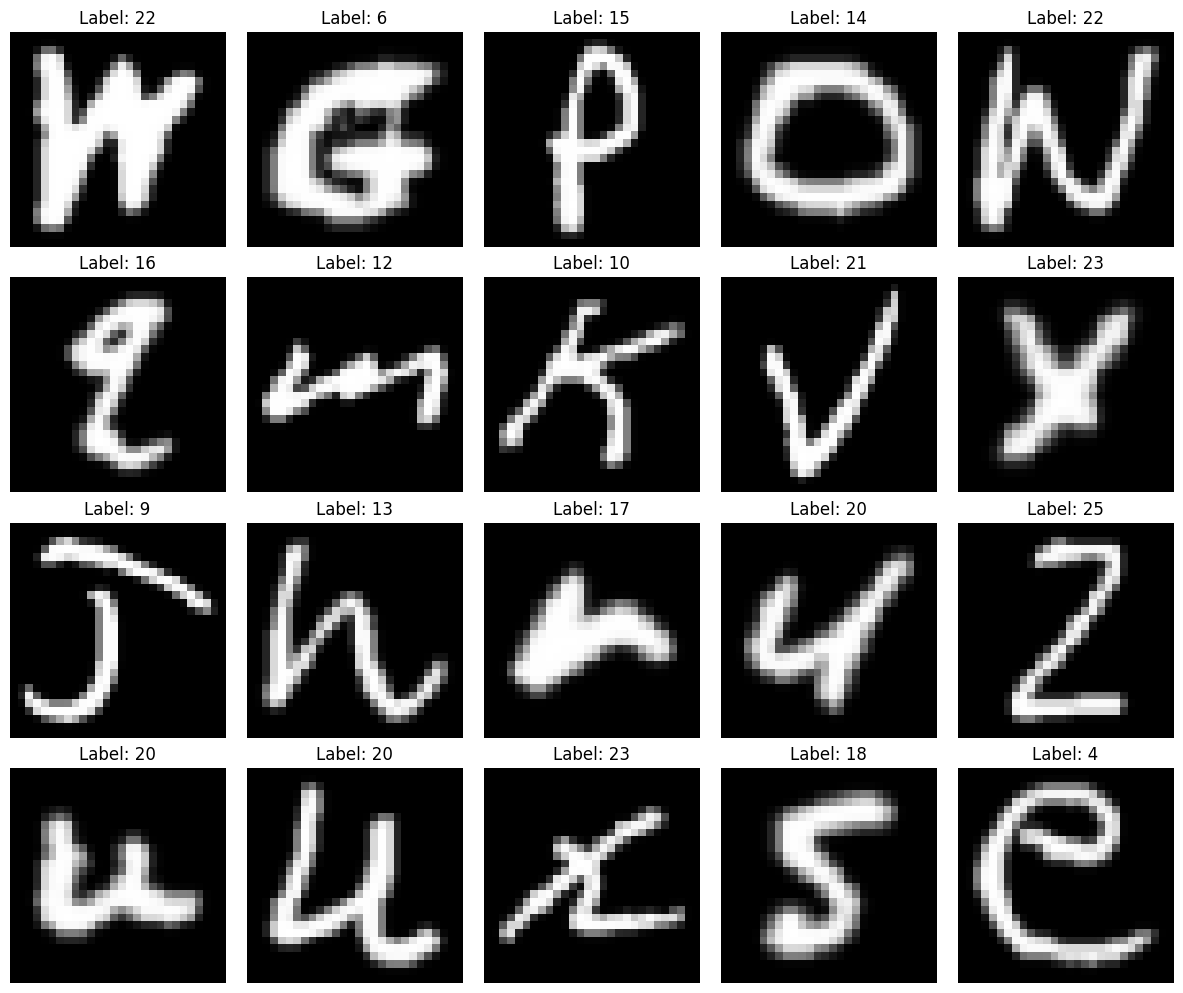

In [ ]:
train_dataset = Hw3Dataset(path_to_folder, 'hw3-letters-train-images-idx3-ubyte', 'hw3-letters-train-labels-idx1-ubyte')
plot_images(train_dataset, num_images=20)


CNN Class

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=16 * 4 * 4, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs


Defining Hyperparameters

In [ ]:
import torch.optim as optim

learning_rate = 0.001
num_epochs = 10
batch_size = 64

In [ ]:
model = LeNet5(n_classes=26)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=26, bias=True)
  )
)

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = Hw3Dataset(path_to_folder, 'hw3-letters-train-images-idx3-ubyte', 'hw3-letters-train-labels-idx1-ubyte', transform=data_transform)
test_dataset = Hw3Dataset(path_to_folder, 'hw3-letters-test-images-idx3-ubyte', 'hw3-letters-test-labels-idx1-ubyte', transform=data_transform)
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=batch_size)

Loading images from file: hw3-letters-train-images-idx3-ubyte
Loading labels from file: hw3-letters-train-labels-idx1-ubyte
Loading images from file: hw3-letters-test-images-idx3-ubyte
Loading labels from file: hw3-letters-test-labels-idx1-ubyte


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_train_loss:.4f}")



Epoch [1/10] - Loss: 0.7040
Epoch [2/10] - Loss: 0.3110
Epoch [3/10] - Loss: 0.2570
Epoch [4/10] - Loss: 0.2287
Epoch [5/10] - Loss: 0.2090
Epoch [6/10] - Loss: 0.1927
Epoch [7/10] - Loss: 0.1807
Epoch [8/10] - Loss: 0.1691
Epoch [9/10] - Loss: 0.1594
Epoch [10/10] - Loss: 0.1511


After training, we can evaluate the model on the validation set.


In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f'Validation Accuracy: {validation_accuracy:.2f}%')


Validation Accuracy: 92.20%


In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 92.01%


Note: I hadn't run the code below because I had been erroring on the CNN training (before adding the -1 to the labels).

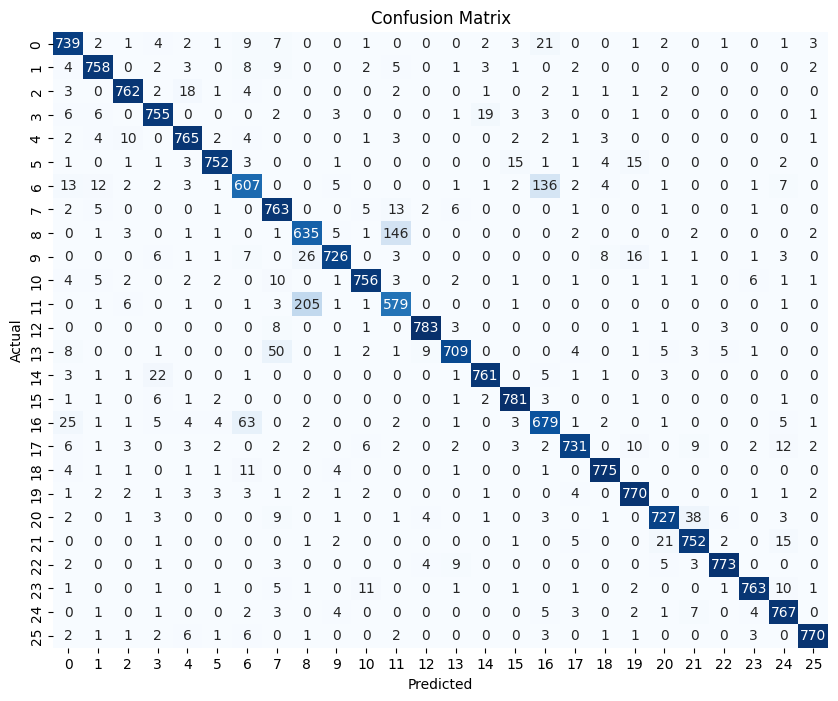

In [ ]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs, _ = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()